In [1]:
# for breast cancer
# import package
from sklearn.datasets import load_breast_cancer
# -----------manipulate data package-----------
import pandas as pd
import numpy as np
# -----------machine learning package-----------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,DMatrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

# -----------ploting package-----------
import matplotlib
import matplotlib.pyplot as plt
# for plot showing log in xscale
matplotlib.rc('font', family='Arial')
%matplotlib inline 
# plot in jupyter

In [2]:
# load data csv or db
# load breast cancer dataset
cancer = load_breast_cancer()
data_ay = np.c_[cancer.data, cancer.target]

columns = np.append(cancer.feature_names, ["target"])
data = pd.DataFrame(data_ay, columns=columns)

no_cancer = data[data['target']==0].copy().reset_index(drop=True)
cancered = data[data['target']==1].copy().reset_index(drop=True)

print(len(no_cancer),len(cancered))
canceredc = cancered.copy()

212 357


In [3]:
SBS_list = ['mean concave points', 'mean fractal dimension', 'texture error', 'area error'\
 , 'compactness error', 'worst texture', 'worst symmetry']
# 用特徵篩選完的欄位
X = data[SBS_list].values
y = data.iloc[:,-1].values.astype('int32')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [4]:
pipe_rf = Pipeline([('scl',StandardScaler()),('rf',RandomForestClassifier(random_state=1,))])

In [5]:
pipe_rf.fit(X_train,y_train)
print('Train Accuracy:%.3f' % pipe_rf.score(X_train,y_train))
print('Test Accuracy:%.3f' % pipe_rf.score(X_test,y_test))

Train Accuracy:1.000
Test Accuracy:0.956


In [6]:
# https://github.com/barrachri/imbalanced_datasets/blob/master/utils.py

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    The returned matrix is normalized but shows the original value
    """
    
    plt.figure(figsize=SIZE_IMAGE)
    
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_n, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm_n.max() / 3.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        color="white" if cm_n[i, j] > thresh else "black"
        
        value_normalized = cm_n[i, j]
        value = cm[i, j] 
        
        # print original values
        plt.text(j, i, format(value),
                 horizontalalignment="center",
                 verticalalignment='top',
                 color=color)
        
        # print normalized values
        plt.text(j, i, format(value_normalized,'.2f'),
                 horizontalalignment="center",
                 verticalalignment='bottom',
                 color=color)  
          

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

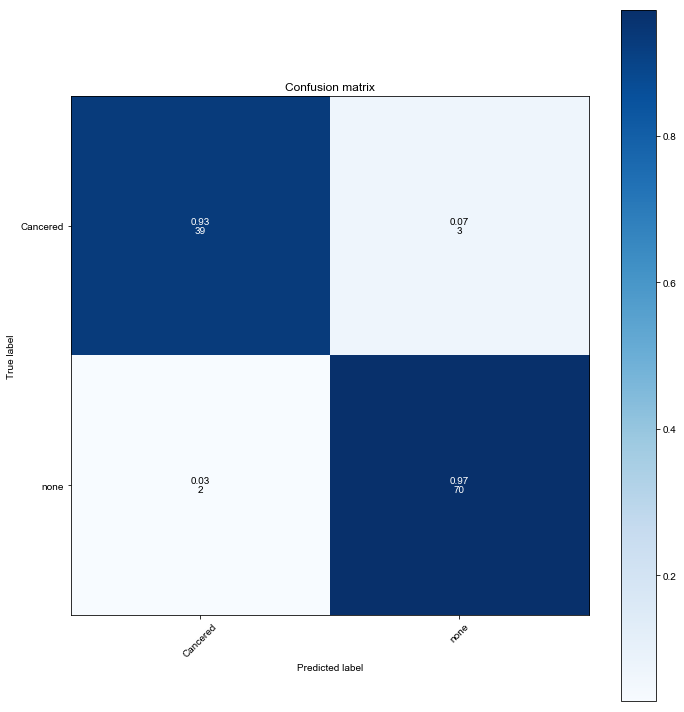

In [7]:
## confusion matrix for check classification good or bad

y_pred = pipe_rf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

classes = ("Cancered", "none")
SIZE_IMAGE = (10,10)
import itertools
plot_confusion_matrix(confmat, classes=classes, title='Confusion matrix')

In [13]:
X_train.shape

(455, 7)

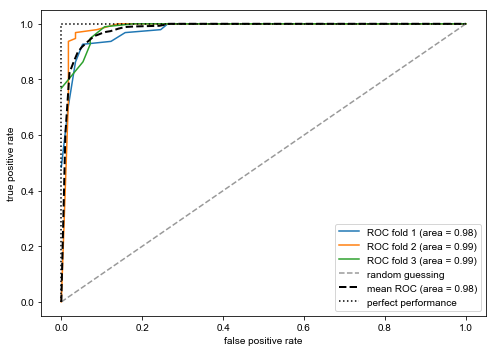

In [10]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
    
kfold = StratifiedKFold(n_splits=3,random_state=1)


cv = list(kfold.split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_rf.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score,accuracy_score
print("ROC AUC:%.3f" %roc_auc_score(y_true=y_test,y_score=y_pred))
print("Accuravy:%.3f" %accuracy_score(y_true=y_test,y_pred=y_pred))

ROC AUC:0.950
Accuravy:0.956
